# **Chapter 1: Preprocessing Single-subject Data**

***

In this single-subject analysis chapter, EEG pre-processing has been divided into the following 8 steps:

- **Step 1: Loading data**  
- **Step 2: Filtering data**  
- **Step 3: Rejecting artifacts**  
- **Step 4: Setting the reference**  
- **Step 5: Segmenting data into epochs**  
- **Step 6: Data averaging**  
- **Step 7: Time-frequency analysis**
- **Step 8: Data extraction**

Required Python packages:
**[NumPy](https://numpy.org/)** and **[MNE-Python](https://mne.tools/stable/index.html)**  
Run the following codes in terminal to install：
> pip install numpy  
> pip install mne

# Step 1 Loading data

### Reading raw data

Since MATLAB-based EEGLAB is the the most widely used EEG data analysis toolbox that most researchers are more familar with, here we use the classic dataset ('eeglab_data.set') in EEGLAB as an example to teach you how to use Python to deal with EEG data.

In [1]:
import numpy as np
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

# About data path - If dataset has been downloaded in the sample_data folder of the EEGLAB folder, 
# navigate to your Downloads directory 

data_path = "/Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_data.set"

# Multiple formats of EEG data are supported in MNE-Python:

# *** If the data suffix is '.set '(Data from EEGLAB)
#     use mne.io.read_raw_eeglab()
# *** If the data suffix is '.vhdr' (BrainVision)
#     use mne.io.read_raw_brainvision()
# *** If the data suffix is '.edf'
#     use mne.io.read_raw_edf()
# *** If the data suffix is '.bdf' (BioSemi)
#     use mne.io.read_raw_bdf()
# *** If the data suffix is '.gdf'
#     use mne.io.read_raw_gdf()
# *** If the data suffix is '.cnt' (Neuroscan)
#     use mne.io.read_raw_cnt()
# *** If the data suffix is '.egi' or '.mff'
#     use mne.io.read_raw_egi()
# *** If the data suffix is '.data'
#     use mne.io.read_raw_nicolet()
# *** If the data suffix is '.nxe' (Nexstim eXimia)
#     use mne.io.read_raw_eximia()
# *** If the data suffix is '.lay' or '.dat' (Persyst)
#     use mne.io.read_raw_persyst()
# *** If the data suffix is '.eeg' (Nihon Kohden)
#     use mne.io.read_raw_nihon()

# Reading data
raw = mne.io.read_raw_eeglab(data_path, preload=True)

Reading /Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_data.fdt
Reading 0 ... 30503  =      0.000 ...   238.305 secs...


### Checking raw data information

In [2]:
print(raw)
print(raw.info)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 000, EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


We can get some basic and important information of the EEG data:
32 channels with 30504 time points; sampling rate is 128Hz; data length is 238.3s; data size is about 7.5 MB. 
Here, we set preload=True when we load the data, so the data is preloaded into memory.  
The names of channels are 'EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', etc.  
The data hasn't been referenced.  
0.0Hz High-pass filtering and 64.0 Hz low-pass filtering.  

### Localizing channels

Here, the channel names in this dataset are not using standard names.
If you face similar situations, you need to manually import the electrode location information of the EEG data.  
In this case, the dataset is associated with a .locs file which includes electrode location information. Thus, we need to pass this information into our EEG data.

In [3]:
# .locs filepath
locs_info_path = "/Users/zitonglu/Desktop/EEG/eeglab14_1_2b/sample_data/eeglab_chan32.locs"
# import channel location information
montage = mne.channels.read_custom_montage(locs_info_path)
# import correct channel names
new_chan_names = np.loadtxt(locs_info_path, dtype=str, usecols=3)
# get old channel names
old_chan_names = raw.info["ch_names"]
# create a dictionary to match old channel names and new (correct) channel names
chan_names_dict = {old_chan_names[i]:new_chan_names[i] for i in range(32)}
# update the channel names in the dataset
raw.rename_channels(chan_names_dict)
#  check location information
raw.set_montage(montage)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

If the EEG data (hat & recording system) you are working with belongs to a specific systems, you might be able to directly use mne.channels.make_standard_montage function to generate channel location information.  
Take the standard international 10-20 system as an example, the corresponding code could be changed as follows:

> montage = mne.channels.make_standard_montage("standard_1020")   

The available montage of channel location information from other systems in MNE can be found at the following website:

[https://mne.tools/stable/generated/mne.channels.make_standard_montage.html#mne.channels.make_standard_montage](https://mne.tools/stable/generated/mne.channels.make_standard_montage.html#mne.channels.make_standard_montage)

### Setting channel types

In [4]:
# The default type of channels in MNE is eeg.
# Here, we need to set the channel type of two EOG channels as eog

chan_types_dict = {"EOG1":"eog", "EOG2":"eog"}
raw.set_channel_types(chan_types_dict)

<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

### Checking data information after modification

In [5]:
# Print information about the modified data

print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: FPz, EOG1, F3, Fz, F4, EOG2, FC5, FC1, FC2, FC6, T7, C3, C4, Cz, ...
 chs: 30 EEG, 2 EOG
 custom_ref_applied: False
 dig: 32 items (32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


### Visualizing raw data

Plot raw data waveforms

Using matplotlib as 2D backend.
Opening raw-browser...


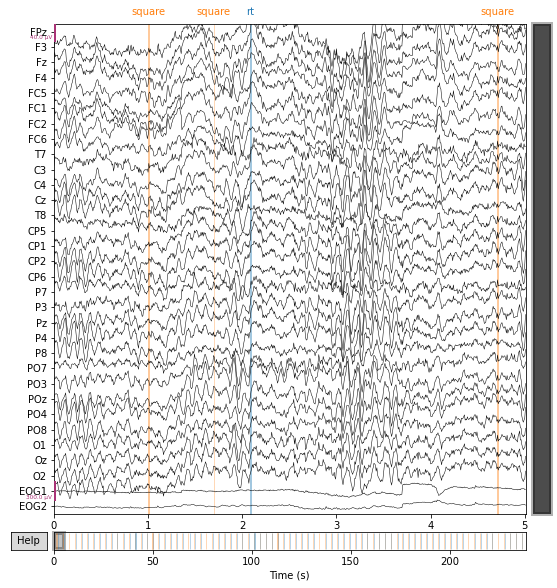

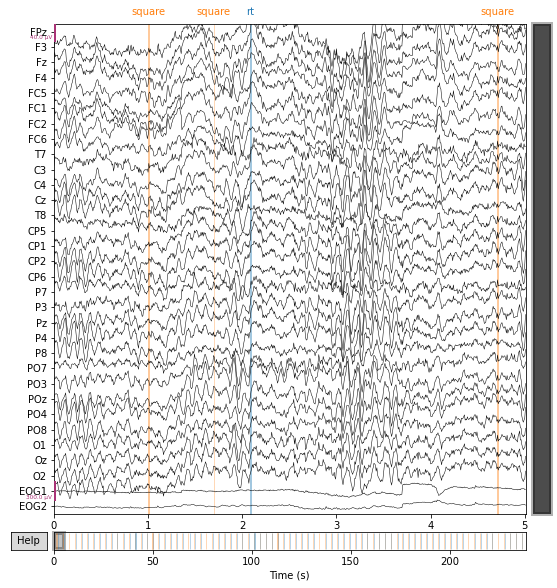

In [6]:
raw.plot(duration=5, n_channels=32, clipping=None)

Plot power spectral density across channels

Effective window size : 16.000 (s)


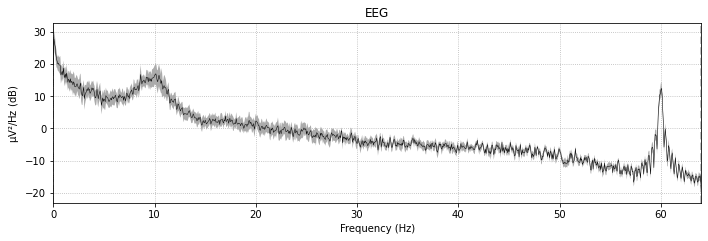

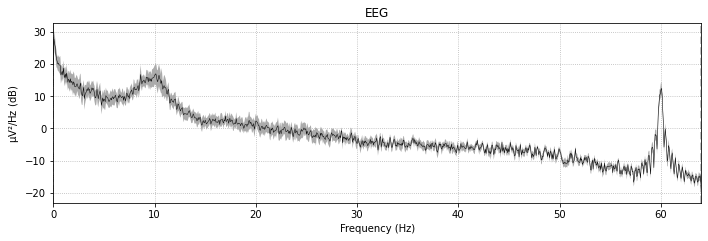

In [7]:
raw.plot_psd(average=True)

Plot the channel locations map

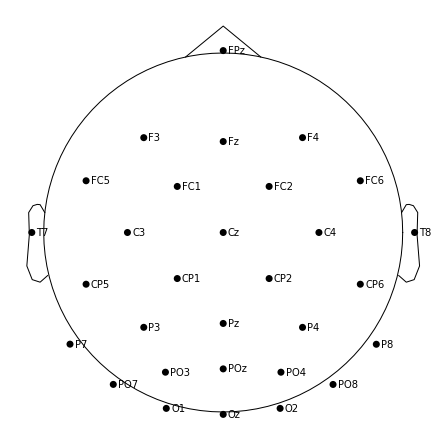

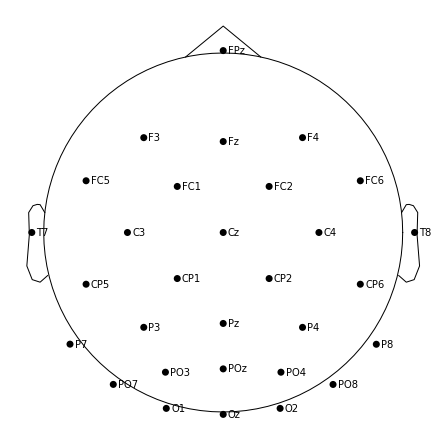

In [8]:
raw.plot_sensors(ch_type='eeg', show_names=True)

Plot channel-wise frequency spectra as topography

Effective window size : 16.000 (s)


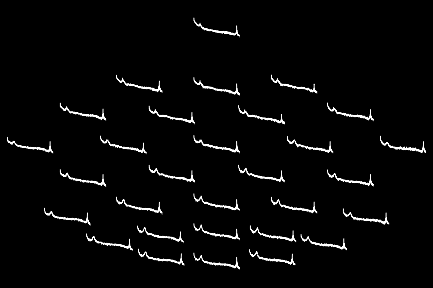

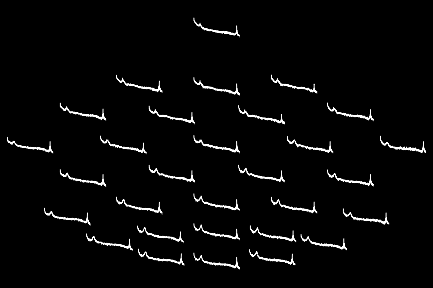

In [9]:
raw.plot_psd_topo()

# Step 2 Filtering data

### Notch filtering

Through the power spectrum in Step 1, we can see that there might be ambient noise at around 60Hz.  
Here first use the trap filter to remove utility frequency.
Different countries and areas may have different utility frequencies. Remember to judge it by the power spectrum.

In [10]:
raw = raw.notch_filter(freqs=(60))

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)



Plot the power spectrum

Effective window size : 16.000 (s)


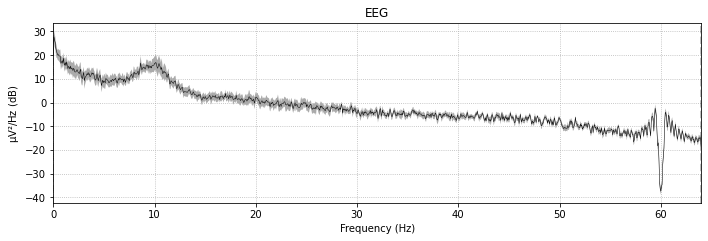

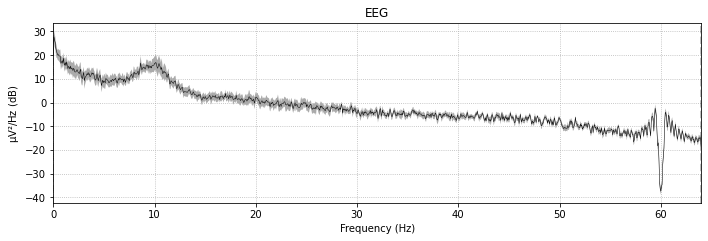

In [11]:
raw.plot_psd(average=True)

### Hight/Low-pass filtering

In pre-processing, the high-pass filtering is usually a necessary step.  
The most common filtering operation is to use a low-pass filter at 30 Hz and a high-pass filter at 0.1 Hz.  
High-pass filtering is used to eliminate voltage drift, and low-pass filtering is used to eliminate high frequency noises.

In [12]:
raw = raw.filter(l_freq=0.1, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4225 samples (33.008 sec)



In MNE, the default filtering method is FIR. If you want to use IIR filtering method, you can just modify the parameter method:  
method='fir' by default, using IIR is to set method='iir'.  
The corresponding code is below:

> raw = raw.filter(l_freq=0.1, h_freq=30, method='iir')

Plot the power spectrum

Effective window size : 16.000 (s)


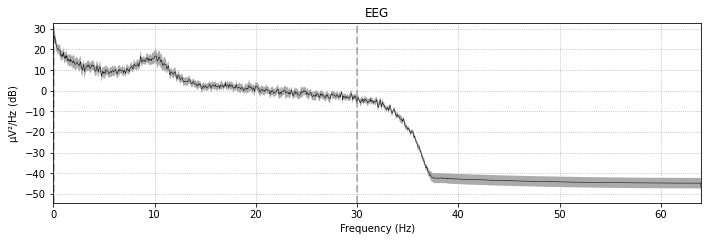

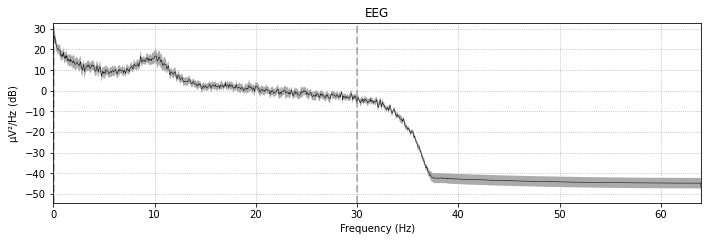

In [13]:
raw.plot_psd(average=True)

# Step 3 Rejecting artifacts

### Remove bad segments

Bad segment marking can be done manually via MNE-Python GUI

> fig = raw.plot(duration=5, n_channels=32, clipping=None)  
> fig.canvas.key_press_event('a')

Press 'a' to open this small GUI window, then press 'add new label' to add a marker for marking bad segments  
In MNE, the bad segments will be not deleted directly. But the data will be marked with bad markers.  
In the subsequent data processing, we can set the parameter 'reject_by_annotation' as True in functions to automatically exclude the marked segments while doing data processing. 
If you encounter the problem that GUI window isn't pop up, please add the following code on the top of the script.

> import matplotlib  
> matplotlib.use('TkAgg')

**Note**: Not recommend to open GUI in Jupyter notebook (GUI always crashes).

### Remove bad channels

The bad channels in MNE will be also not deleted directly. MNE just marks the bad channels with 'bads' labels.
In the example below, we assume that channel 'FC5' is bad. Thus, we can mark 'FC5' as 'bads'.

In [14]:
# Marking the bad channel
raw.info['bads'].append('FC5')
# Printing the bad channel's name
print(raw.info['bads'])

['FC5']


Of course, we can add multiple bad channels  
For example, if both 'FC5' and 'C3' are bad channels, we can mark them via the following line：
> raw.info['bads'].extend(['FC5', 'C3']) 

### Reconstruct bad channels

The bad channel reconstruction of MNE is to reconstruct signal of the channels marked as 'bads'

In [15]:
raw = raw.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors


The bad 'bads' marker will be removed by default after signal reconstruction.  
If you do not want to remove the markings of the original bad channels, set the reset_bads parameter as False.  
The corresponding code is as follow:

> raw = raw.interpolate_bads(reset_bads=False)

### Independent Components Analysis (ICA)

Run ICA

The programming idea of ICA in MNE is to first build an ICA object (which can be understood as building an ICA analyzer) then use this ICA analyzer to analyze the EEG data (through methods of ICA object).  
Since ICA is not effective for low frequency data, here ICA and artifact components removal are based on high-pass 1Hz data and then applied to high-pass 0.1Hz data.

In [16]:
ica = ICA(max_iter='auto')
raw_for_ica = raw.copy().filter(l_freq=1, h_freq=None)
ica.fit(raw_for_ica)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 29 components
Fitting ICA took 2.9s.


<ICA | raw data decomposition, method: fastica (fit in 72 iterations on 30504 samples), 29 ICA components explaining 100.0 % of variance (30 PCA components available), channel types: eeg, no sources marked for exclusion>

We set n_components here, i.e. the number of ICA components which is automatically selected by MNE's ICA analyzer.  
Similar to EEGLAB, if you want the number of ICA components to be fixed, you can customize the setting (n_components<=n_channels).  
Taking 30 independent components as an example, the corresponding code can be changed as follows：

> ica = ICA(n_components=30, max_iter='auto')

Plot the timing signal of each component

Creating RawArray with float64 data, n_channels=31, n_times=30504
    Range : 0 ... 30503 =      0.000 ...   238.305 secs
Ready.
Opening ica-browser...


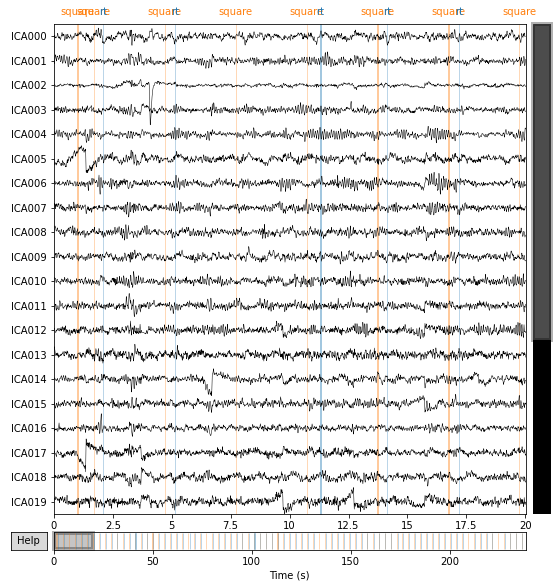

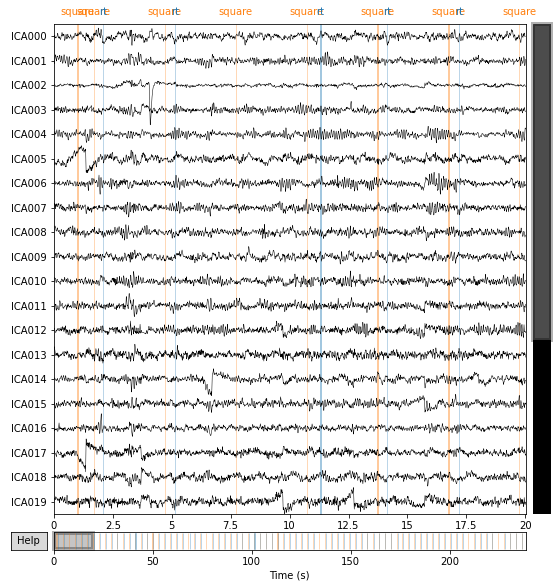

In [17]:
ica.plot_sources(raw_for_ica)

Plot the topography of each component

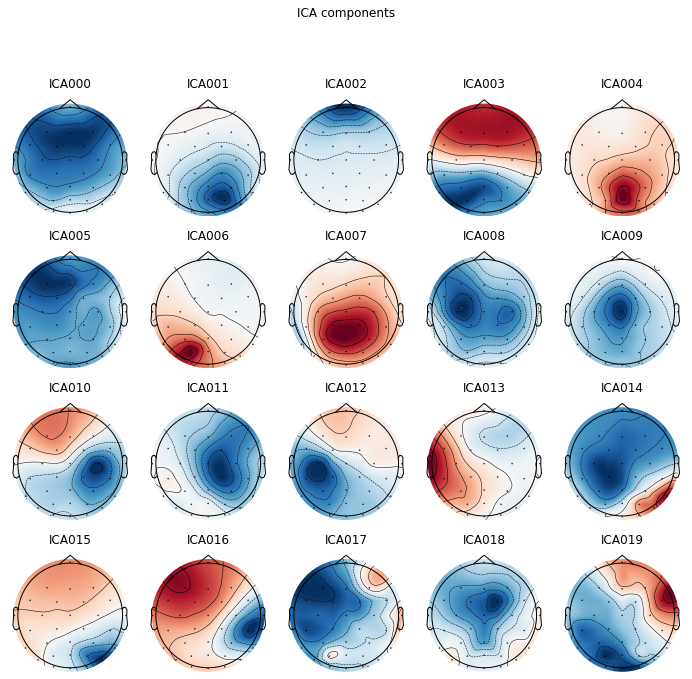

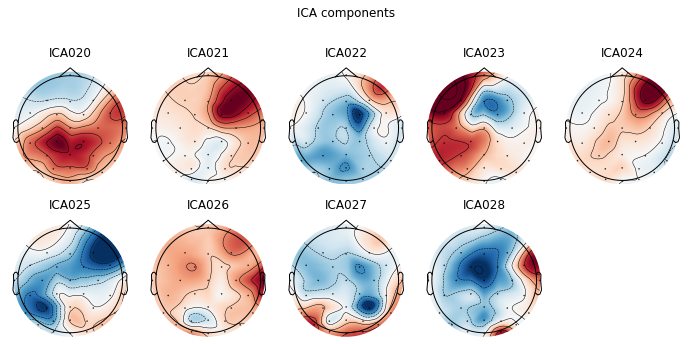

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x357.12 with 9 Axes>]

In [18]:
ica.plot_components()

Check the signal difference before and after the removal of a component / several component.

Here is an example of removing the 3rd component (i.e. ICA002)

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


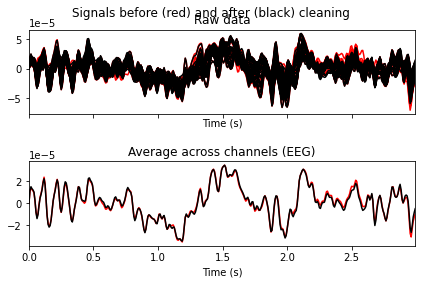

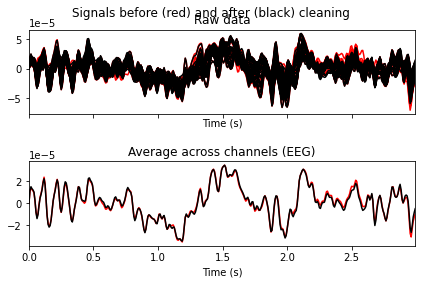

In [19]:
ica.plot_overlay(raw_for_ica, exclude=[2])

Visualize each component

In the example, we visualize the 3nd component (ICA002).

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


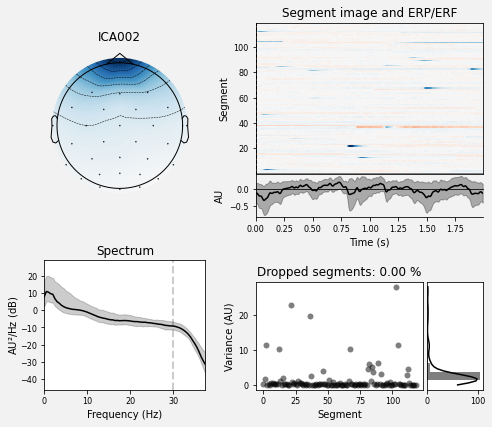

[<Figure size 504x432 with 6 Axes>]

In [20]:
ica.plot_properties(raw, picks=[2])

The power of component ICA002 is higher in the frontal area and is higher at low frequencies, with significant enhancement in some trials.  
It can be judged as an EOG component.  
Component ICA016 does not look like an abnormal component.

#### Exclude components

In [21]:
# set the component index(es) to exclude
ica.exclude = [2]
# apply to EEG data
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawEEGLAB | eeglab_data.fdt, 32 x 30504 (238.3 s), ~7.5 MB, data loaded>

Plot the waveform of the data after ICA

Opening raw-browser...


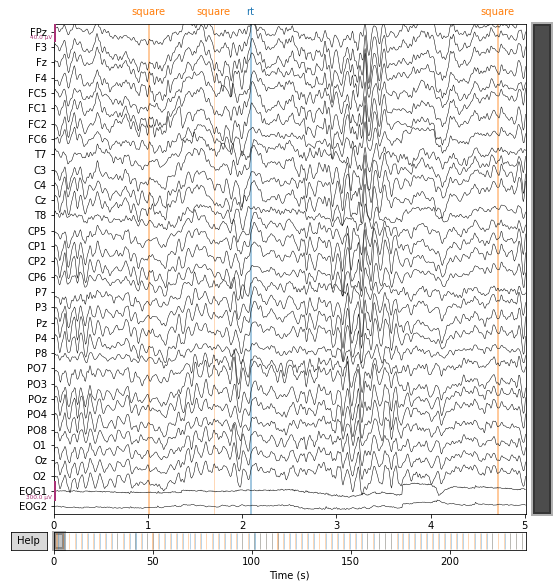

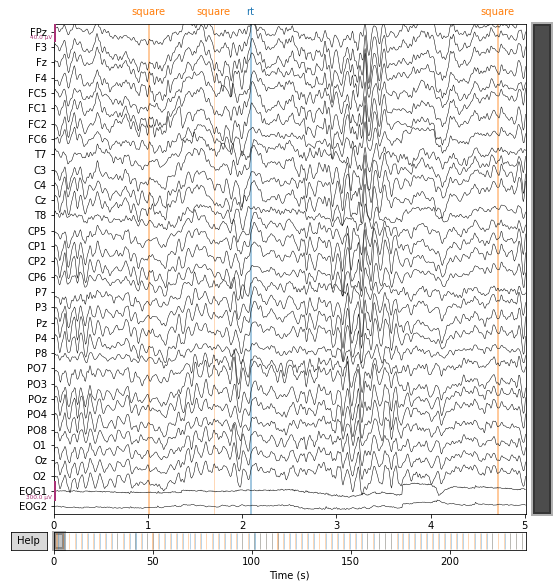

In [22]:
raw.plot(duration=5, n_channels=32, clipping=None)

# Step 4 Setting the reference

Since the authors of the 'eeglab_data.set' used the papillary reference, so if the data need to be referenced, we use 'TP9' and 'TP10' as reference channels. You could use the following codes:

> raw.set_eeg_reference(ref_channels=['TP9','TP10'])  

If we want to use the average reference method, you could use the following code:

> raw.set_eeg_reference(ref_channels='average')  

If you want to use the REST reference method, you could use the following code： 
Here you need to pass in a forward parameter, for details see the corresponding MNE introduction at:
[https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html)
> raw.set_eeg_reference(ref_channels='REST', forward=forward)  

If you want to use a bipolar reference method, you could use the following code：
(Here 'EEG X' and 'EEG Y' correspond to the anode and cathode leads used for reference, respectively)

> raw_bip_ref = mne.set_bipolar_reference(raw, anode=['EEG X'], cathode=['EEG Y'])

# Step 5 Segmenting data into epochs

### Extracting events information

First, we need to identify the markers used for the segmentation.  
Check the markers in the data:

In [23]:
print(raw.annotations)

<Annotations | 154 segments: rt (74), square (80)>


It can be seen that the data contains two types of markers, 'square' and 'rt'

MNE has two data structures to store event information, Events and Annotations

For the Annotations object, it uses string to represent the time type, as shown in the printout above.  
The time information is represented as different time- points. And it contains the duration of each marker. If it is a instantaneous marker, the duration is 0.  
The internal data type is List.

In [24]:
# Print event duration of each event in data based on Annotations

print(raw.annotations.duration)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
# Print description information of events in data based on Annotations

print(raw.annotations.description)

['square' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square'
 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'rt'
 'square' 'rt' 'square' 'rt' 'square' 'rt' 'square' 'square' 'rt' 'sq

In [26]:
# Print start time of events in data based on Annotations

print(raw.annotations.onset)

[  1.000068   1.695381   2.082407   4.703193   5.148224   7.711006
  10.718818  11.303858  13.726631  14.116658  16.734443  17.187474
  19.742256  20.199287  22.750068  23.136095  25.757881  26.124906
  28.765693  29.140719  31.773506  32.116529  34.781318  35.24635
  37.789131  38.254163  40.796943  41.229973  43.804756  44.30079
  46.812568  47.156592  49.820381  50.273412  52.828193  53.242222
  55.836006  56.211031  58.843818  59.237845  61.851631  62.183654
  64.859443  65.257471  67.867256  68.598306  70.875068  71.277096
  73.882881  74.323911  76.890693  79.898506  80.269531  82.906318
  83.312346  85.914131  86.313158  88.921943  89.280968  91.929756
  92.323783  94.937568  95.296593  97.945381  98.37141  100.953193
 101.363221 103.961006 104.332031 106.968818 107.343844 109.976631
 110.425662 112.984443 113.410472 115.992256 116.367281 119.000068
 119.359093 122.007881 122.409908 125.015693 125.441722 128.023506
 128.422533 131.031318 131.433346 134.039131 137.046943 137.4889

For the Events object, it is an event record data type used for data segmentation.  
It uses 'Event ID' which is an integer to encode the event type, and represents the time in the form of samples.  
And it does not contain the duration information of the marker. Its internal data type is NumPy-Array.

### Event information data type conversion

Convert event information of Annotations to Events:

In [27]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['rt', 'square']


'events' is the matrix of time related records. 'event_id' is the dictionary information of different markers.  
Here, we print the shape and event_id of the events matrix.

In [28]:
print(events.shape, event_id)

(154, 3) {'rt': 1, 'square': 2}


'rt' marker corresponds to the number 1, 'square' marker corresponds to the number 2.  
There are 154 markers in total.

### Segmentating data

Data segmentation is based on Events.  
Here, we extract the data from 1 second before the stimullus to 2 seconds after the stimulus, i.e. the data from -1s to 2s with the 'square' marker.  
Take the baseline time interval from 0.5s before the stimulus to the onset of the stimulus. And set a threshold to exclude epochs i.e., the epoch that the difference between the largest and smallest values in it is greater than 2×10^-4 then will be excluded.  
**Note**: The threshold value we use here is pretty larger. Generally we recommend you to set the threshold between 5×10^-5 and 1×10^4 for good data quality.

In [29]:
epochs = mne.Epochs(raw, events, event_id=2, tmin=-1, tmax=2, baseline=(-0.5, 0), 
                    preload=True, reject=dict(eeg=2e-4))

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 80 events and 385 original time points ...
0 bad epochs dropped


The segmented data is stored as the Epochs object.  
Print epochs to see the information about the segmented data.

In [30]:
print(epochs)

<Epochs |  80 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~7.6 MB, data loaded,
 '2': 80>


### Visualizing segmented data

Visualize the segmented data (here, we show 4 epochs).

Opening epochs-browser...


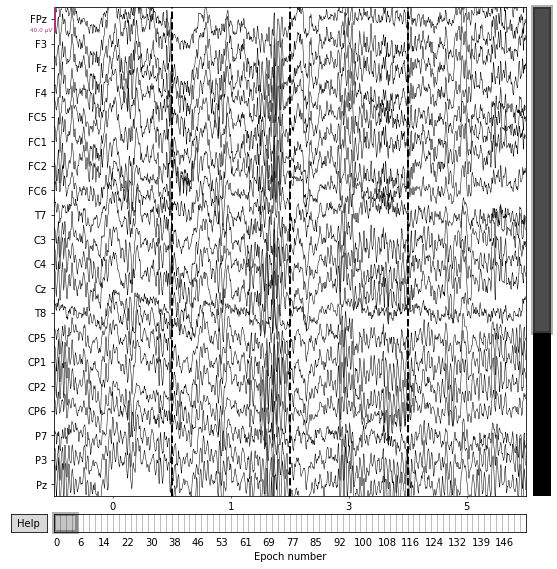

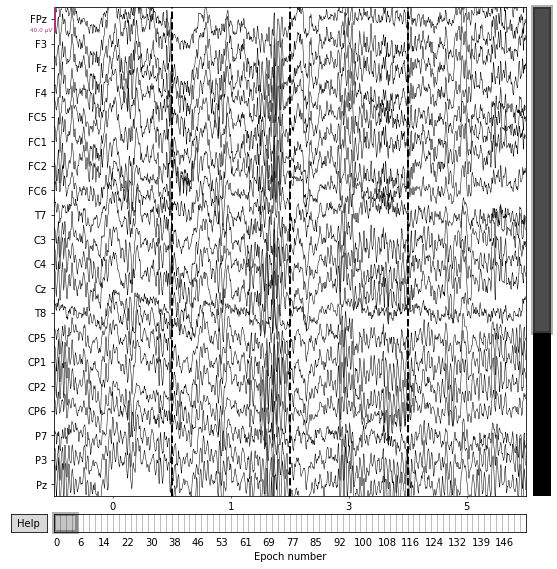

In [31]:
epochs.plot(n_epochs=4)

Plot the power spectrum (channel-by-channel):

    Using multitaper spectrum estimation with 7 DPSS windows


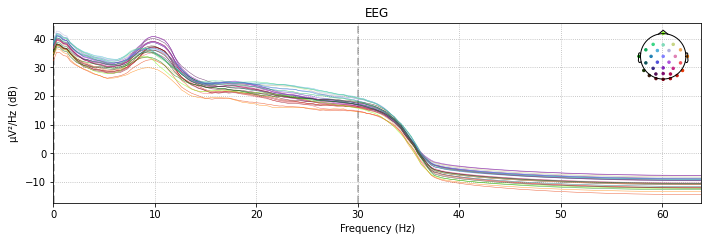

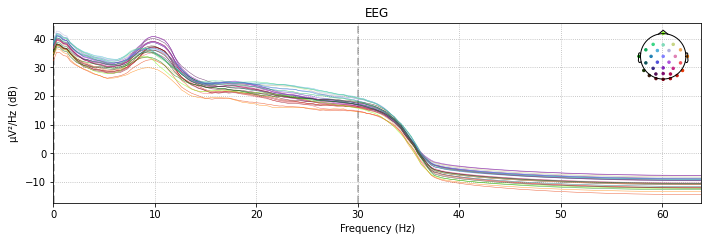

In [32]:
epochs.plot_psd(picks='eeg')

Plot the power spectrum topology (of Theta, Alpha and Beta bands):

    Using multitaper spectrum estimation with 7 DPSS windows


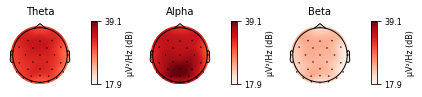

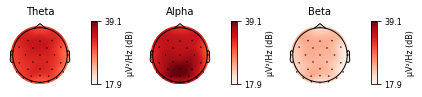

In [33]:
bands = [(4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta')]
epochs.plot_psd_topomap(bands=bands, vlim='joint')

# Step 6 Data averaging

MNE uses the Epochs Class to store segmented data and the Evoked Class to store evoked (after averaging) data

### Average data

In [34]:
evoked = epochs.average()

### Visualize evoked data

Plot channel-wise timing signals

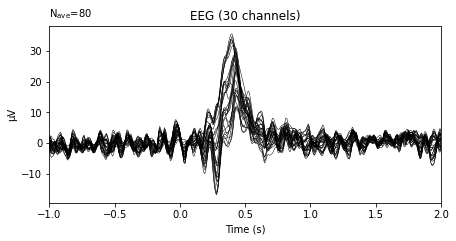

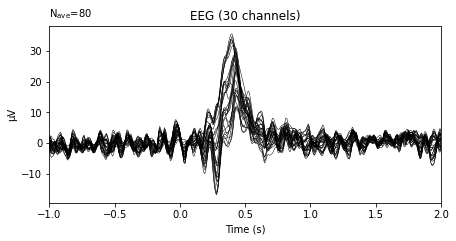

In [35]:
evoked.plot()

Plot topographic maps

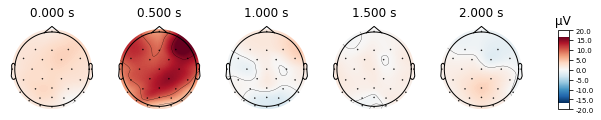

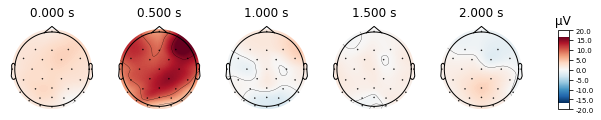

In [36]:
# Plot the topographic map at 0ms、0.5s、1s、1.5s and 2s
times = np.linspace(0, 2, 5)
evoked.plot_topomap(times=times, colorbar=True)

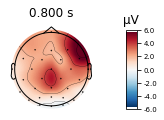

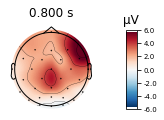

In [37]:
# Plot the topographic map at a particular time-point
# In this example, we plot the figure at 0.8s
# where we take the mean value from 0.75 to 0.85s

evoked.plot_topomap(times=0.8, average=0.1)

Plot evoked data as butterfly plot and add topomaps

No projector specified for this dataset. Please consider the method self.add_proj.


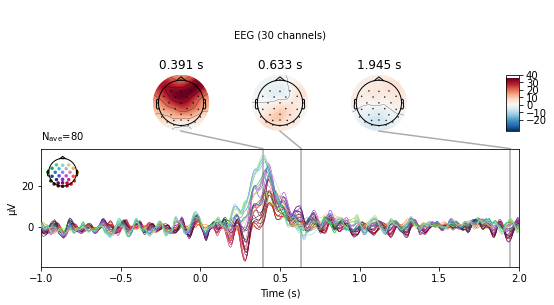

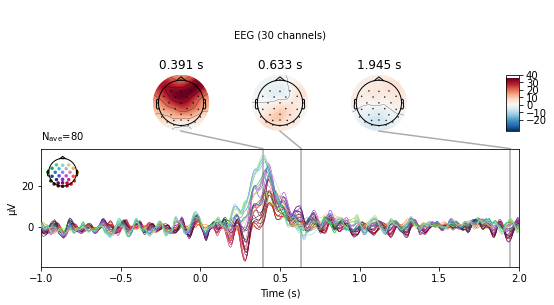

In [38]:
evoked.plot_joint()

Plotting channel-wise hotmaps

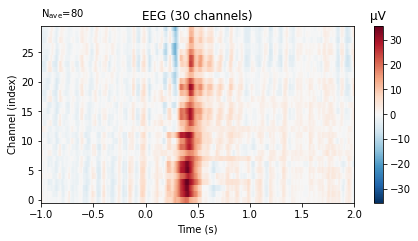

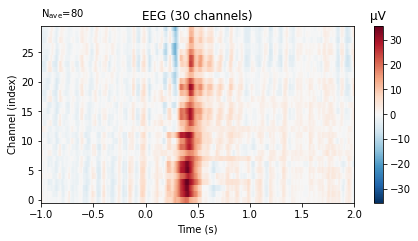

In [39]:
evoked.plot_image()

Plot 2D topography

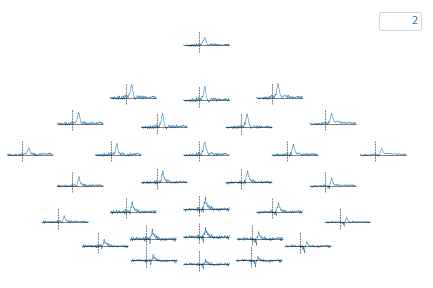

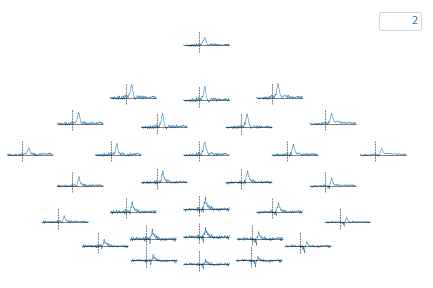

In [40]:
evoked.plot_topo()

Plot the averaged ERP of all channels

combining channels using "mean"


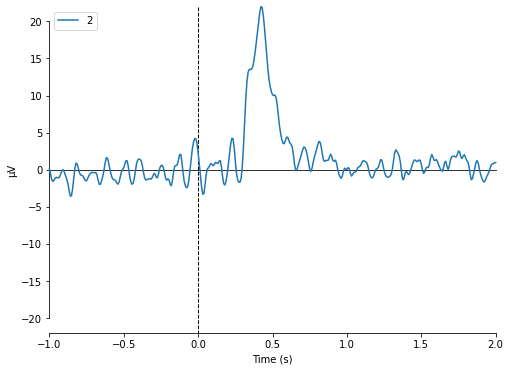

[<Figure size 576x432 with 1 Axes>]

In [41]:
mne.viz.plot_compare_evokeds(evokeds=evoked, combine='mean')

Plotting the averaged ERP of occipital channels

combining channels using "mean"


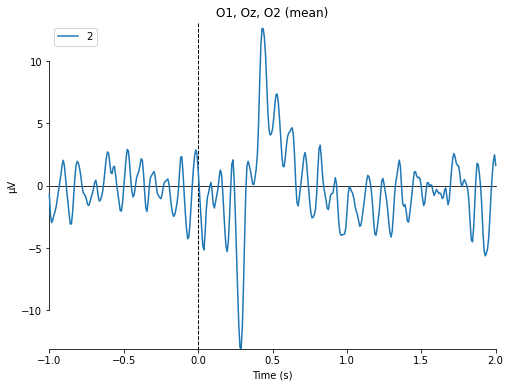

[<Figure size 576x432 with 1 Axes>]

In [42]:
mne.viz.plot_compare_evokeds(evokeds=evoked, picks=['O1', 'Oz', 'O2'], combine='mean')

# Step 7 Time-frequency Analysis

MNE provides three methods for time-frequency analysis, which are
- Morlet wavelets, corresponding to mne.time_frequency.tfr_morlet()  
- DPSS tapers, corresponding to mne.time_frequency.tfr_multitaper()  
- Stockwell Transform, corresponding to mne.time_frequency.tfr_stockwell()

Here, the first method is used as an example:

### Conduct Time-frequency analysis

Calculate Power and inter-trial coherence (ITC)

In [43]:
# Set some parameters for time-frequency analysis
# The frequency band is selected from 4 to 30 Hz

freqs = np.logspace(*np.log10([4, 30]), num=10)
n_cycles = freqs / 2.
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True)

The returned power is the Power result, and itc is the inter-trial coupling result.  
MNE returns the average result of all trials by default.  
If you want to get the separate time-frequency analysis results of each trial, you can just set the average parameter to False.  
The corresponding code can be modified as follows:
> power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False)

### Plot the time-frequency result

The visualization methods of time-frequency in MNE allows us to select different baseline correlation methods
The corresponding parameter is mode, which includes the following options:  
- 'mean', to subtract the baseline mean  
- 'ratio', to divide by the baseline mean  
- 'logratio', to divide by the baseline mean and take log  
- 'percent', to subtract the baseline mean and divide by the baseline mean  
- 'zscore', to subtract the baseline mean and divide by the baseline standard deviation  
- 'zlogratio', to divide by the baseline mean and take the log and then divide by the standard deviation of the baseline after taking the log  

In the following example, the logratio method is chosen for baseline correction.

Plot power result of occipital channels

Applying baseline correction (mode: logratio)


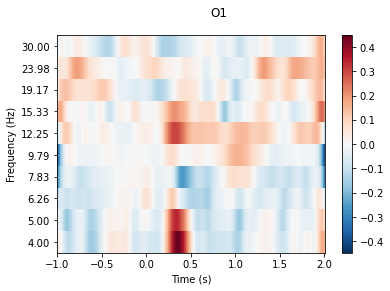

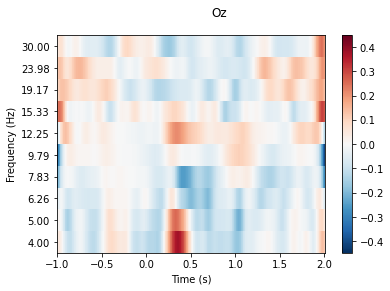

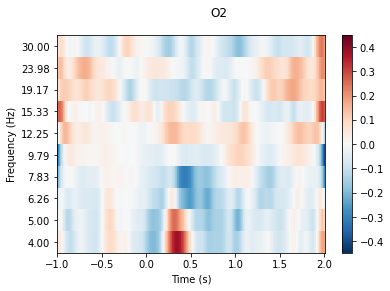

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [44]:
power.plot(picks=['O1', 'Oz', 'O2'], baseline=(-0.5, 0), mode='logratio', title='auto')

Plot mean power result of occipital channels

Applying baseline correction (mode: logratio)


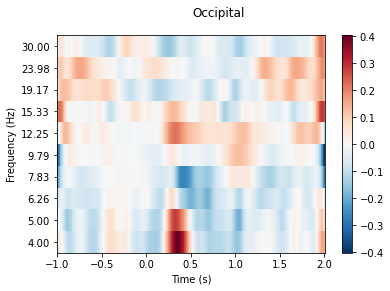

[<Figure size 432x288 with 2 Axes>]

In [45]:
power.plot(picks=['O1', 'Oz', 'O2'], baseline=(-0.5, 0), mode='logratio', title='Occipital', combine='mean')

Plot 2D power topology

Applying baseline correction (mode: logratio)


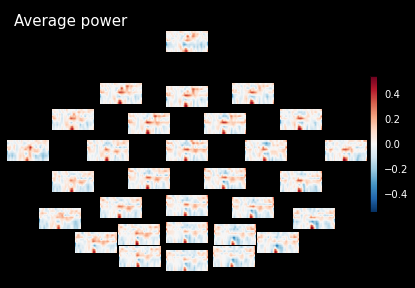

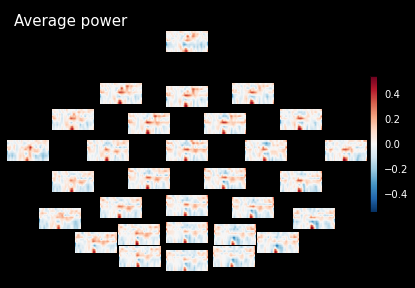

In [46]:
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')

Plot power topology for different frequencies

Applying baseline correction (mode: logratio)


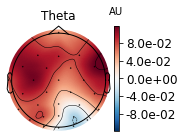

Applying baseline correction (mode: logratio)


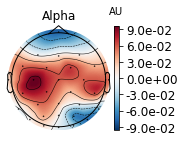

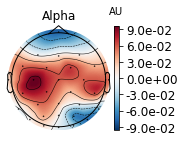

In [47]:
# Take theta power and alpha powers as an example
# Take the result of 0-0.5s

power.plot_topomap(tmin=0, tmax=0.5, fmin=4, fmax=8, 
                   baseline=(-0.5, 0), mode='logratio', title='Theta')
power.plot_topomap(tmin=0, tmax=0.5, fmin=8, fmax=12, 
                   baseline=(-0.5, 0), mode='logratio', title='Alpha')

Plot joint figures

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


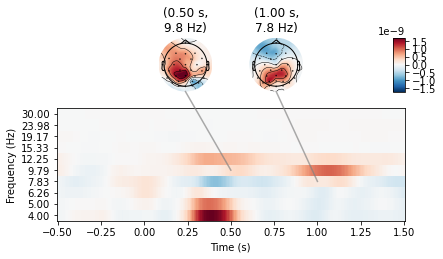

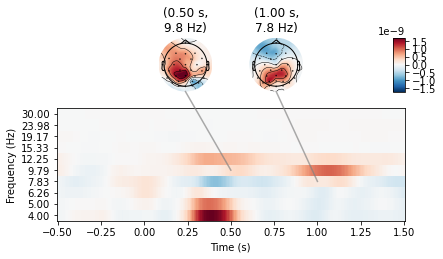

In [48]:
# And plot the results around 10Hz at 0.5s and around 8Hz at 1s
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-0.5, tmax=1.5,
                 timefreqs=[(0.5, 10), (1, 8)])

ITC results are plotted in similar ways. Below is an example of plotting ITC topology.

Applying baseline correction (mode: logratio)


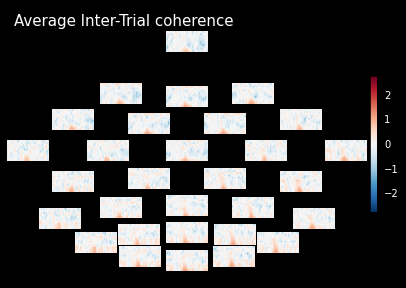

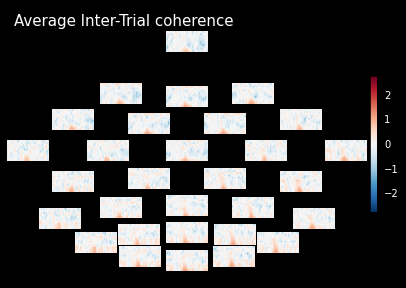

In [49]:
itc.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average Inter-Trial coherence')

# Step 8 Data extraction

After completing the relevant calculations, we always want to extract the raw data matrix, segmented data matrix, time-frequency result matrix, etc.  
In MNE, Raw Class (raw data type), Epochs Class (segmented data type) and Evocked Class (averaged data type) provide get_data() method. And AverageTFR Class (time-frequency analysis data type) provides the .data attribute.

### Use get_data()

Take epochs as an example:

In [50]:
epochs_array = epochs.get_data()

Check the data:

In [51]:
print(epochs_array.shape)
print(epochs_array)

(80, 32, 385)
[[[ 9.53211134e-06  2.43820219e-05  2.77456690e-05 ...  6.49897265e-06
    5.85175831e-06  2.40034796e-06]
  [ 1.90724252e-05  3.49982830e-05  1.52169891e-05 ... -6.16457047e-05
   -6.91169876e-05 -4.49072670e-05]
  [ 1.96477657e-05  3.52076516e-05  3.87393410e-05 ...  1.78294721e-05
    2.21784082e-05  2.34076318e-05]
  ...
  [-9.28002300e-07  8.05858902e-06  1.19529290e-05 ...  2.82049105e-05
    2.51630659e-05  2.70634345e-05]
  [-2.57653092e-06  7.24605703e-06  1.03968208e-05 ...  1.93071498e-05
    1.68748332e-05  2.34502948e-05]
  [ 1.06979050e-07  1.23600287e-05  1.50094522e-05 ...  1.05924847e-05
    9.54948165e-06  2.08057969e-05]]

 [[-2.74043775e-05 -2.33313314e-05 -2.42491775e-05 ... -7.88883572e-06
   -1.00384183e-05 -6.38075157e-06]
  [-1.98700747e-05 -2.32499213e-05 -2.34376177e-05 ... -5.87000498e-05
   -6.47002100e-05 -5.75247492e-05]
  [-4.73790585e-05 -4.25695976e-05 -4.61766852e-05 ... -1.80899699e-05
   -1.82851837e-05 -1.10958311e-05]
  ...
  [-1.603

Thus we can obtain the segmented data (NumPy Array type), and its shape is [80, 32, 385] which corresponds to 80 trials, 32 channels and 385 time points respectively.

If you want to obtain EEG data (exclude EOG or other channels' data), the above code can be modified to:

> epochs_array = epochs.get_data(picks=['eeg'])

### Use .data

In [52]:
power_array = power.data

Check the data:

In [53]:
print(power_array.shape)
print(power_array)

(30, 10, 385)
[[[8.79362042e-10 9.01897651e-10 9.14871571e-10 ... 1.23067851e-09
   1.24156675e-09 1.23197016e-09]
  [7.31117643e-10 7.62678765e-10 7.85721359e-10 ... 9.78789519e-10
   9.66578461e-10 9.40007218e-10]
  [6.85212068e-10 7.32769552e-10 7.73843832e-10 ... 9.41478222e-10
   8.94225200e-10 8.38834624e-10]
  ...
  [8.72062577e-11 9.27116716e-11 9.75722789e-11 ... 1.03182051e-10
   9.75252287e-11 9.12525091e-11]
  [5.91042577e-11 6.34050984e-11 6.73394158e-11 ... 6.80569101e-11
   6.43019283e-11 6.01728767e-11]
  [3.73592423e-11 3.91737950e-11 4.05514460e-11 ... 4.32911704e-11
   4.17672396e-11 3.97972663e-11]]

 [[2.08501752e-09 2.15810078e-09 2.20848505e-09 ... 3.25108975e-09
   3.28484701e-09 3.26743178e-09]
  [1.67740504e-09 1.76811117e-09 1.84109464e-09 ... 2.56512297e-09
   2.53926978e-09 2.47655550e-09]
  [1.49770849e-09 1.61636492e-09 1.72371062e-09 ... 2.30810605e-09
   2.20923306e-09 2.08771785e-09]
  ...
  [1.96055179e-10 2.07742579e-10 2.17846915e-10 ... 2.28354711e

Thus, we can obtain the power result of time-frequency (NumPy Array type), and its shape is [30, 10, 385] which corresponds to 30 channels, 10 frequencies and 385 time points, respectively.